In [107]:
!pip install emcee
!pip install corner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 47.4/47.4 kB 2.2 MB/s eta 0:00:00


In [108]:
import numpy as np
from google.colab import drive
import matplotlib.pyplot as plt
import pandas as pd
drive.mount('/content/drive', force_remount=True)
from IPython.display import clear_output
import time
from tqdm import tqdm
from matplotlib  import cm
import emcee
import corner
import os

Mounted at /content/drive


In [2]:
file = '/content/drive/MyDrive/HiggsFitting.csv'
file

'/content/drive/MyDrive/HiggsFitting.csv'

In [3]:
data = pd.read_csv(file,sep=',')
data.keys()

Index(['Higgs'], dtype='object')

In [6]:
X = np.array(data['Higgs'])
X

array([110.78833312, 104.85217   , 104.3060318 , ..., 123.05224637,
       125.46722845, 124.84467973])

<ErrorbarContainer object of 3 artists>

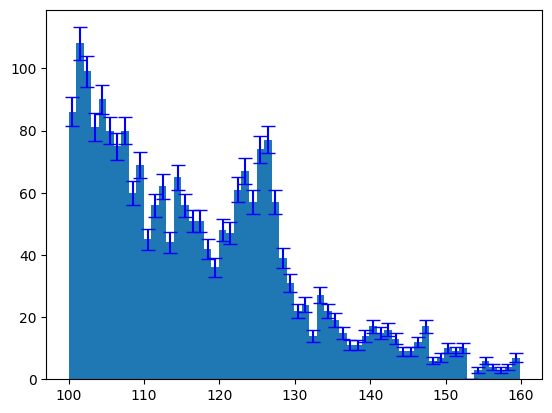

In [22]:
g = np.histogram(X,bins=60,density=True)
f = np.histogram(X,bins=60)
plt.hist(X,bins=60)
x = (f[1][:-1] + f[1][1:]) / 2
plt.errorbar(x,f[0], yerr=0.5*np.sqrt(f[0]), fmt="none", ecolor="blue", capsize=5)

In [19]:
def L(a,x):
  return (1/a)*(np.exp(-(x-100)/a))

In [20]:
def LMin(a,x):
  return -np.sum(np.log(L(a,x)))

In [21]:
a0 = 1
import scipy.optimize as spo
result = spo.minimize(LMin,a0,args=(X),bounds = ( (0,50), ))
result.x

<ipython-input-19-8135d8ccad76>:2: RuntimeWarning: divide by zero encountered in divide
  return (1/a)*(np.exp(-(x-100)/a))
<ipython-input-19-8135d8ccad76>:2: RuntimeWarning: invalid value encountered in multiply
  return (1/a)*(np.exp(-(x-100)/a))
<ipython-input-20-b8588be04505>:2: RuntimeWarning: divide by zero encountered in log
  return -np.sum(np.log(L(a,x)))


array([17.61887464])

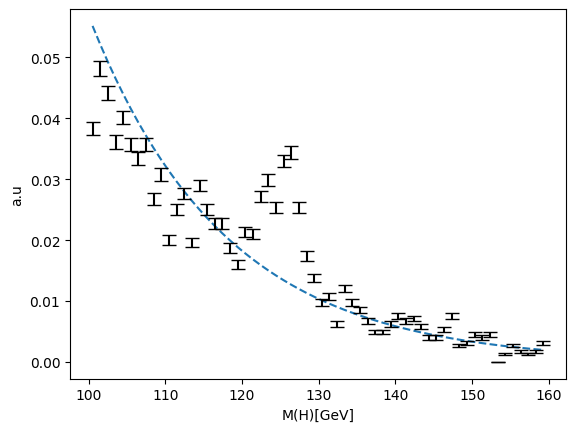

In [30]:
plt.plot(x, L(result.x,x), linestyle="--",label ="b best fit")
plt.errorbar(x,g[0], yerr=0.5*np.sqrt(g[0]/np.sum(x)), fmt="none", ecolor="k",capsize=5)
plt.xlabel("M(H)[GeV]")
plt.ylabel("a.u")
plt.show()

In [67]:
def LAlternative(A,miu,sigma,a,x):
  return A*(1/(np.sqrt(2*np.pi*(sigma**2))))*np.exp(-(x-miu)**2/(2*sigma**2))+ (1-A)*(1/a)*(np.exp(-(x-100)/a))

In [68]:
def LMinAlternative(p,x):
  A,miu,sigma,a = p
  return -np.sum(np.log(LAlternative(A,miu,sigma,a,x)))

In [71]:
a = result.x[0]
args0 = np.array([1,100.,50.,a])
result1 = spo.minimize(LMinAlternative,args0,args=(X),bounds = ( (0,1),(50,500),(1,100), (1,100)))
result1.x

array([  0.14211128, 125.19841239,   2.77540527,  16.3631214 ])

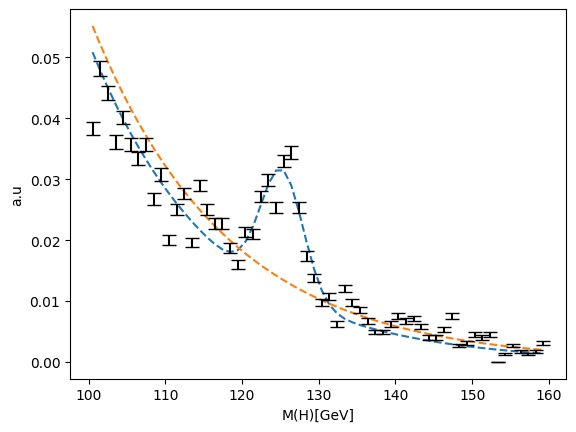

In [81]:
plt.plot(x, LAlternative(*result1.x,x), linestyle="--",label ="b best fit")
plt.plot(x, L(result.x,x), linestyle="--",label ="s+b best fit")
plt.errorbar(x,g[0], yerr=0.5*np.sqrt(g[0]/np.sum(x)), fmt="none", ecolor="k",capsize=5)
plt.xlabel("M(H)[GeV]")
plt.ylabel("a.u")
plt.show()

In [91]:
NDesvesta = np.sqrt(-2*np.log(LMinAlternative(result1.x,X))/LMin(result.x,X))
NDesvesta


<ipython-input-91-190ec3e61fec>:1: RuntimeWarning: invalid value encountered in sqrt
  NDesvesta = np.sqrt(-2*np.log(LMinAlternative(result1.x,X))/LMin(result.x,X))


nan

In [95]:
h = 1.015*1e-23
sigma1 = result1.x[2]
T = h/sigma1
T

3.6571235639693815e-24

In [100]:
def LogPrior(p):
  A,miu,sigma,a=p
  if 0. < A < 1. and 50. < miu < 500. and 1< sigma < 100. and 1 < a < 100:
    return 0.0
  else:
    return -np.inf

In [110]:
def JointLikelihood2(p,v):
  return np.sum( np.log(LAlternative(*p,v)))

In [111]:
def LogPosterior(p,x):

  LogP = LogPrior(p)
  if not np.isfinite(LogP):
    return -np.inf
  else:
    return LogP + JointLikelihood2(p,x)

In [112]:
# Paquete
n_walkers, n_params = 10,4
p0 = np.zeros((n_walkers, n_params))
p0[:,0] = result1.x[0]
p0[:,1] = result1.x[1]
p0[:,2] = result1.x[2]
p0[:,3] = result1.x[3]
p0 += np.random.rand(n_walkers, n_params)

In [113]:
sampler = emcee.EnsembleSampler(n_walkers, n_params, LogPosterior, args=(X,))
pos,prob,state = sampler.run_mcmc(p0,10000,progress=True)

100%|██████████| 10000/10000 [00:22<00:00, 439.92it/s]


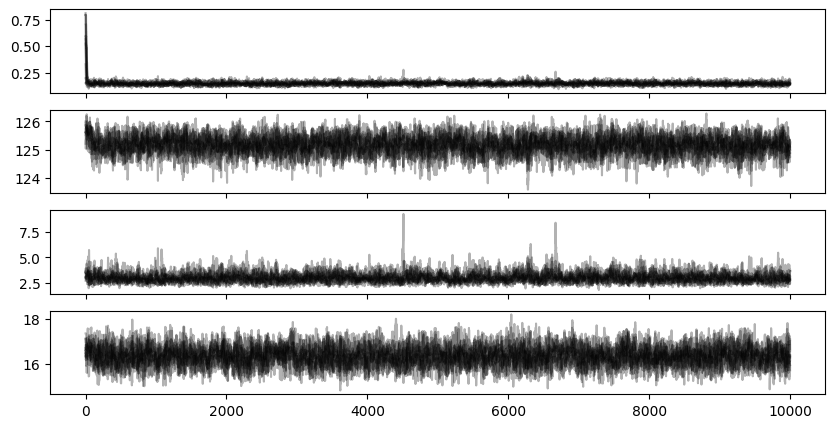

In [124]:
fig, axes = plt.subplots(4, figsize=(10,5), sharex=True)

samples = sampler.get_chain()
labels = ["miu", "sigma"]
for i in range(4):
    ax = axes[i]
    ax.plot(samples[:, :, i], "k", alpha=0.3)

In [115]:
flat_samples = sampler.get_chain(discard=100, thin=15, flat=True)
truths = np.percentile(flat_samples, 50, axis=0)
truths

array([  0.14561167, 125.17609045,   2.90854054,  16.35857   ])

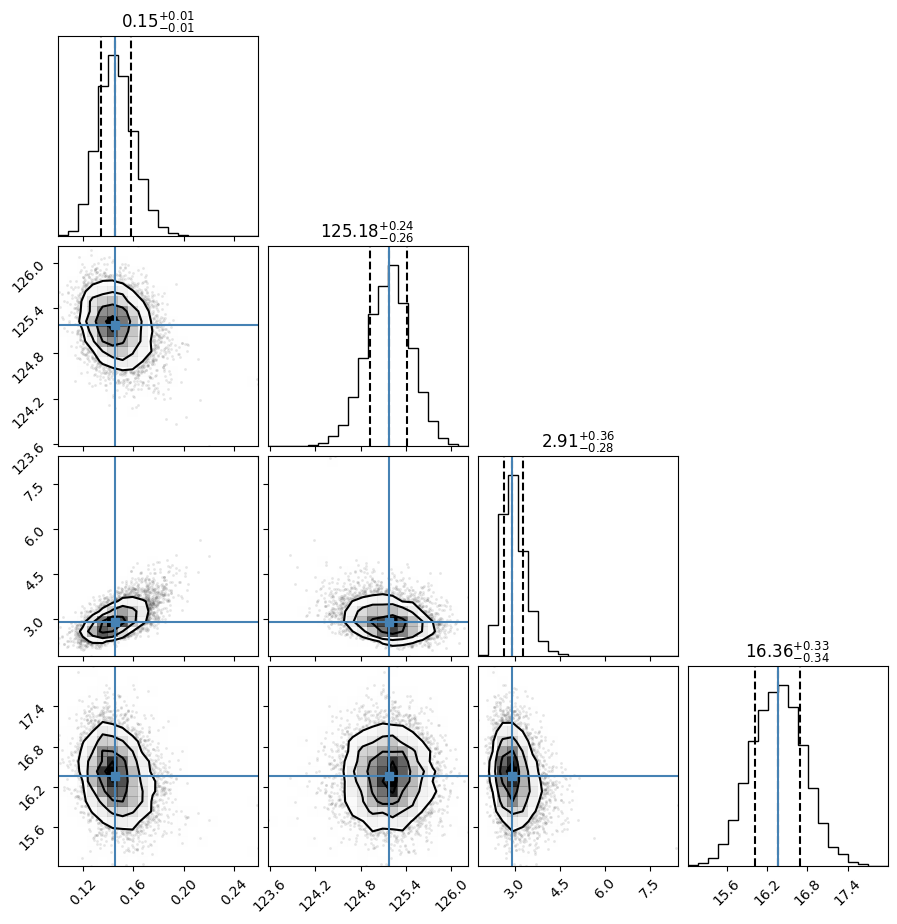

In [119]:
figure = corner.corner(flat_samples, truths=truths, quantiles=[0.20, 0.5, 0.80], show_titles=True)